In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

np.random.seed(34)

2024-01-02 15:20:10.616039: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-02 15:20:10.616115: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-02 15:20:10.617887: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-02 15:20:10.778735: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


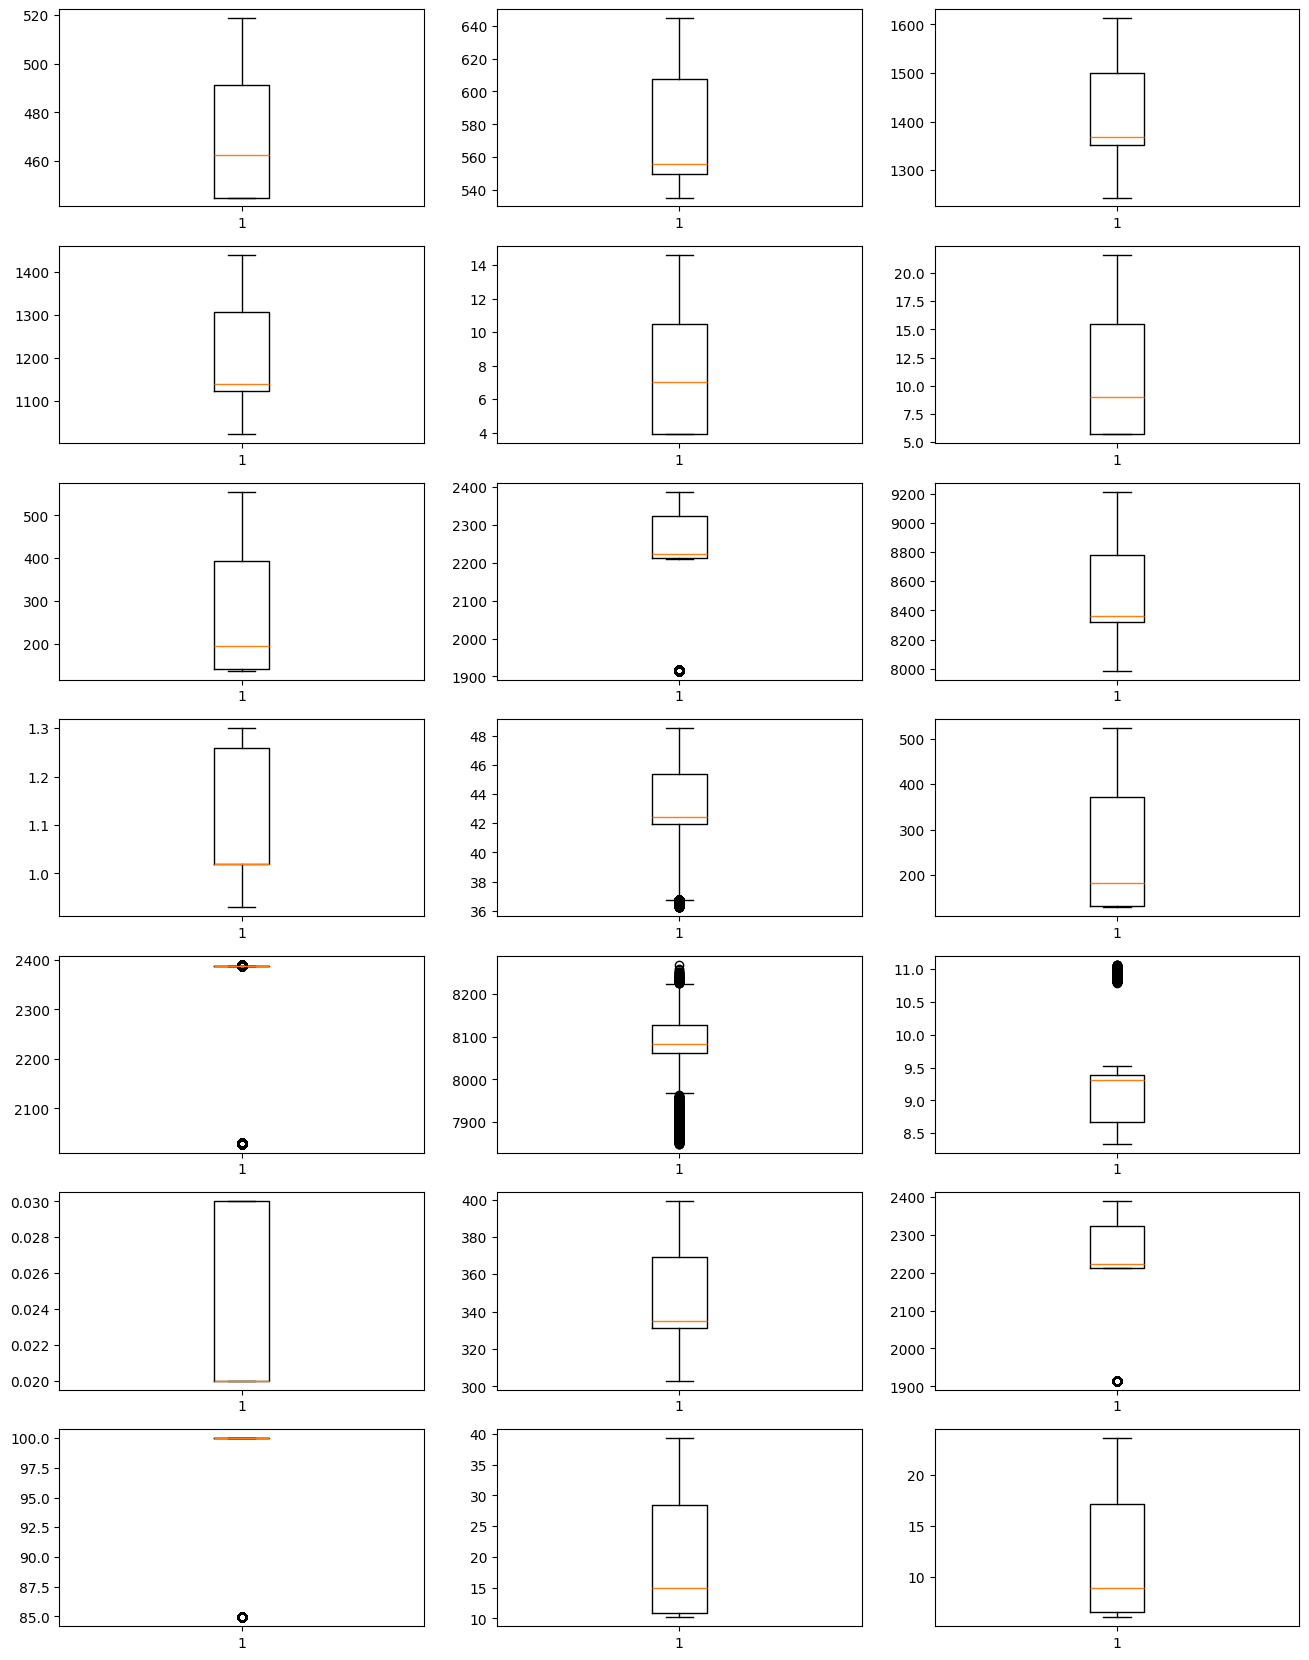

In [2]:
train_data = pd.read_csv("../../CMAPSS/train_FD002.txt", sep= "\s+", header = None)
plt.figure(figsize = (16, 21))
for i in range(21):
    temp_data = train_data.iloc[:,i+5]
    plt.subplot(7,3,i+1)
    plt.boxplot(temp_data)
plt.show()

In [3]:
def process_targets(data_length, early_rul = None):
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length-1, -1, -1)
        else:
            return np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))
        
def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
    """Depending on values of window_length and shift, this function generates batchs of data and targets 
    from input_data and target_data.
    
    Number of batches = np.floor((len(input_data) - window_length)/shift) + 1
    
    **We don't check input dimensions uisng exception handling. So readers should be careful while using these
    functions. If input data are not of desired dimension, either error occurs or something undesirable is 
    produced as output.**
    
    Arguments:
        input_data: input data to function (Must be 2 dimensional)
        target_data: input rul values (Must be 1D array)s
        window_length: window length of data
        shift: Distance by which the window moves for next batch. This is closely related to overlap
               between data. For example, if window length is 30 and shift is 1, there is an overlap of 
               29 data points between two consecutive batches.
        
    """
    num_batches = int(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets
    
    

In [4]:
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):
    """ This function takes test data for an engine as first input. The next two inputs
    window_length and shift are same as other functins. 
    
    Finally it takes num_test_windows as the last input. num_test_windows sets how many examplles we
    want from test data (from last). By default it extracts only the last example.
    
    The function returns last examples, number of last examples (a scaler), a mask, and test_decoder sequence as output. 
    We need the second output later. If we are extracting more than 1 last examples, we have to 
    average their prediction results. The second scaler halps us do just that.
    """
    if len(test_data_for_an_engine) < window_length:
        mask_length = window_length - len(test_data_for_an_engine)
        batched_test_data_for_an_engine = np.concatenate((test_data_for_an_engine,
                                                          np.zeros((mask_length, test_data_for_an_engine.shape[1]))))
        mask = np.concatenate((np.repeat([True], len(test_data_for_an_engine)), np.repeat([False], mask_length)))
        num_test_windows = 1    # This has to be 1 as number of data points is less than window length
        return batched_test_data_for_an_engine[np.newaxis, :], num_test_windows, mask[np.newaxis, :]                                                
    
    else:
        max_num_test_batches = int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
        
        if max_num_test_batches < num_test_windows:
            required_len = (max_num_test_batches -1)* shift + window_length
            batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                              target_data = None,
                                                                              window_length = window_length, shift = shift)
            m, n = batched_test_data_for_an_engine.shape[0], batched_test_data_for_an_engine.shape[1]
            mask = np.repeat([True], m * n).reshape(m, n)
            return batched_test_data_for_an_engine, max_num_test_batches, mask
        
        else:
            required_len = (num_test_windows - 1) * shift + window_length
            batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                              target_data = None,
                                                                              window_length = window_length, shift = shift)
            m, n = batched_test_data_for_an_engine.shape[0], batched_test_data_for_an_engine.shape[1]
            mask = np.repeat([True], m * n).reshape(m, n)
            return batched_test_data_for_an_engine, num_test_windows, mask

In [5]:
test_data = pd.read_csv("../../CMAPSS/test_FD002.txt", sep = "\s+", header = None)
true_rul = pd.read_csv("../../CMAPSS/RUL_FD002.txt", sep = '\s+', header = None)

window_length = 30
shift = 1
early_rul = 150         
processed_train_data = []
processed_train_targets = []

# How many test windows to take for each engine. If set to 1 (this is the default), only last window of test data for 
# each engine is taken. If set to a different number, that many windows from last are taken. 
# Final output is the average output of all windows.
num_test_windows = 5     
processed_test_data = []
num_test_windows_list = []
test_mask = []

columns_to_be_dropped = [0,1,2,3,4]

train_data_first_column = train_data[0]
test_data_first_column = test_data[0]

#Scale data for all engines
scaler = MinMaxScaler(feature_range = (-1, 1))
#scaler = StandardScaler()
train_data = scaler.fit_transform(train_data.drop(columns = columns_to_be_dropped))
test_data = scaler.transform(test_data.drop(columns = columns_to_be_dropped))

train_data = pd.DataFrame(data = np.c_[train_data_first_column, train_data])
test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_data])

num_train_machines = len(train_data[0].unique())
num_test_machines = len(test_data[0].unique())

# Process training and test data sepeartely as number of engines in training and test set may be different.
# As we are doing scaling for full dataset, we are not bothered by different number of engines in training and test set.

# Process trianing data
for i in np.arange(1, num_train_machines + 1):
    temp_train_data = train_data[train_data[0] == i].drop(columns = [0]).values
    
    # Verify if data of given window length can be extracted from training data
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
        
    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets, 
                                                                                window_length = window_length, shift = shift)
    
    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

# Process test data
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values


    # Prepare test data
    test_data_for_an_engine, num_windows, test_mask_for_an_engine = process_test_data(temp_test_data,
                                                                                      window_length = window_length,
                                                                                      shift = shift,
                                                                                      num_test_windows = num_test_windows)
    
    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)
    test_mask.append(test_mask_for_an_engine)

processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values
test_mask = np.concatenate(test_mask)

# Shuffle training data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]

print("Processed trianing data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)
print("Processed test data shape: ", processed_test_data.shape)
print("Test mask shape: ", test_mask.shape)
print("True RUL shape: ", true_rul.shape)

Processed trianing data shape:  (46219, 30, 21)
Processed training ruls shape:  (46219,)
Processed test data shape:  (1267, 30, 21)
Test mask shape:  (1267, 30)
True RUL shape:  (259,)


In [6]:
processed_train_data, processed_val_data, processed_train_targets, processed_val_targets = train_test_split(processed_train_data,
                                                                                                            processed_train_targets,
                                                                                                            test_size = 0.2,
                                                                                                            random_state = 38)
print("Processed train data shape: ", processed_train_data.shape)
print("Processed validation data shape: ", processed_val_data.shape)
print("Processed train targets shape: ", processed_train_targets.shape)
print("Processed validation targets shape: ", processed_val_targets.shape)

Processed train data shape:  (36975, 30, 21)
Processed validation data shape:  (9244, 30, 21)
Processed train targets shape:  (36975,)
Processed validation targets shape:  (9244,)


# Training LSTM

In [7]:
def custom_loss(y_true, y_pred):
    alpha = 0.2
    difference = y_pred - y_true
    squared_difference = tf.square(y_pred - y_true)
    
    # Calcola la loss per ciascun elemento
    loss = tf.where(difference < 0, 2 * alpha * squared_difference, 2 * (alpha + (1 - 2 * alpha)) * squared_difference)
    
    # Calcola la media delle loss
    return tf.reduce_mean(loss)

In [8]:
from keras.layers import LSTM, Flatten, Dense
from keras.optimizers import Adam
from keras import regularizers 
def createLSTMsmallModel(l1Nodes, l2Nodes, d1Nodes, d2Nodes, input_shape):
    # input layer
    lstm1 = LSTM(l1Nodes, input_shape=input_shape,activation='tanh', return_sequences=True, kernel_regularizer=regularizers.l2(0.1))
    
    lstm2 = LSTM(l2Nodes, return_sequences=True, activation='tanh', kernel_regularizer=regularizers.l2(0.1))    
    flatten = Flatten()
    dense1 = Dense(d1Nodes, activation='relu', kernel_regularizer=regularizers.l2(0.1))
    dense2 = Dense(d2Nodes, activation='relu', kernel_regularizer=regularizers.l2(0.1))
    
    # output layer
    outL = Dense(1, activation='relu', kernel_regularizer=regularizers.l2(0.1))
    
    #layers
    layers = [lstm1, lstm2,flatten,  dense1, dense2, outL]
    model = Sequential(layers)
    #Abbiamo aggiunto le nostre funzioni di loss e accuracy definite precedentemente

    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=custom_loss)
    return model

def createLSTMsmallModelMSE(l1Nodes, l2Nodes, d1Nodes, d2Nodes, input_shape):
    # input layer
    lstm1 = LSTM(l1Nodes, input_shape=input_shape,activation='tanh', return_sequences=True, kernel_regularizer=regularizers.l2(0.1))
    
    lstm2 = LSTM(l2Nodes, return_sequences=True, activation='tanh', kernel_regularizer=regularizers.l2(0.1))    
    flatten = Flatten()
    dense1 = Dense(d1Nodes, activation='relu', kernel_regularizer=regularizers.l2(0.1))
    dense2 = Dense(d2Nodes, activation='relu', kernel_regularizer=regularizers.l2(0.1))
    
    # output layer
    outL = Dense(1, activation='relu', kernel_regularizer=regularizers.l2(0.1))
    
    #layers
    layers = [lstm1, lstm2,flatten,  dense1, dense2, outL]
    model = Sequential(layers)
    #Abbiamo aggiunto le nostre funzioni di loss e accuracy definite precedentemente

    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse")
    return model

In [9]:
lstm_small_quad = createLSTMsmallModel(60, 30, 30, 15, (30, 21))
lstm_small_mse = createLSTMsmallModelMSE(60, 30, 30, 15, (30, 21))

2024-01-02 15:20:18.991753: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-02 15:20:19.025879: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-02 15:20:19.026305: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [10]:

# # def scheduler(epoch, lr):
# #     if epoch < 10:
# #         return lr
# #     elif epoch >= 10 and epoch < 20 :
# #         return 0.001
# #     elif epoch >= 20 and epoch < 30: 
# #         return 0.0001
# #     elif epoch >= 30: 
# #         return 0.00001
# #     else: 
#         return 0.01; 

# callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)

In [11]:
EPOCHS = 50 #50
BATCH_SIZE = 256 #256

history = lstm_small_quad.fit(processed_train_data, processed_train_targets, epochs = EPOCHS, 
                     validation_data = (processed_val_data, processed_val_targets),
                     batch_size=BATCH_SIZE)


Epoch 1/50


2024-01-02 14:25:49.862789: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-01-02 14:25:50.682960: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f0214ec15f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-02 14:25:50.682994: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060 with Max-Q Design, Compute Capability 7.5
2024-01-02 14:25:50.686710: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-02 14:25:50.771084: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


145/145 [==============================] - 6s 14ms/step - loss: 1967.2252 - val_loss: 1523.1215
Epoch 2/50
145/145 [==============================] - 2s 10ms/step - loss: 885.4127 - val_loss: 661.4432
Epoch 3/50
145/145 [==============================] - 2s 11ms/step - loss: 650.1514 - val_loss: 614.9000
Epoch 4/50
145/145 [==============================] - 2s 11ms/step - loss: 622.0820 - val_loss: 560.3603
Epoch 5/50
145/145 [==============================] - 2s 11ms/step - loss: 569.4887 - val_loss: 569.5717
Epoch 6/50
145/145 [==============================] - 2s 11ms/step - loss: 516.4614 - val_loss: 468.8876
Epoch 7/50
145/145 [==============================] - 2s 11ms/step - loss: 484.7356 - val_loss: 481.4191
Epoch 8/50
145/145 [==============================] - 2s 11ms/step - loss: 444.2723 - val_loss: 440.4735
Epoch 9/50
145/145 [==============================] - 1s 10ms/step - loss: 422.7013 - val_loss: 405.6734
Epoch 10/50
145/145 [==============================] - 1s 10ms/s

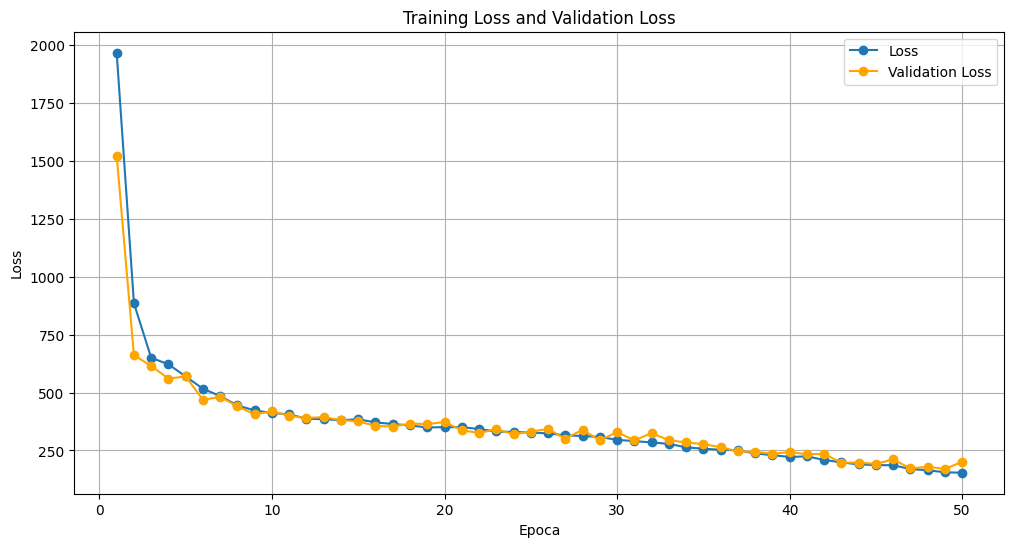

In [12]:
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot della loss function
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(loss) + 1), loss, label='Loss', marker='o')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', marker='o', linestyle='-', color='orange')
plt.title('Training Loss and Validation Loss')
plt.xlabel('Epoca')
plt.ylabel('Loss')
#plt.ylim(0, 600)
plt.legend()
plt.grid(True)
plt.show()

In [12]:
EPOCHS = 50 
BATCH_SIZE = 256
history = lstm_small_mse.fit(processed_train_data, processed_train_targets, epochs = EPOCHS, 
                     validation_data = (processed_val_data, processed_val_targets), 
                     batch_size=BATCH_SIZE)

Epoch 1/50


2024-01-02 15:23:27.166284: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-01-02 15:23:28.011617: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fced809fde0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-02 15:23:28.011659: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060 with Max-Q Design, Compute Capability 7.5
2024-01-02 15:23:28.021625: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-02 15:23:28.190802: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


145/145 [==============================] - 11s 34ms/step - loss: 3336.0552 - val_loss: 2405.8977
Epoch 2/50
145/145 [==============================] - 4s 27ms/step - loss: 2193.7278 - val_loss: 1278.3323
Epoch 3/50
145/145 [==============================] - 3s 24ms/step - loss: 969.2980 - val_loss: 919.4653
Epoch 4/50
145/145 [==============================] - 3s 22ms/step - loss: 862.4276 - val_loss: 917.2132
Epoch 5/50
145/145 [==============================] - 3s 22ms/step - loss: 814.3216 - val_loss: 760.0438
Epoch 6/50
145/145 [==============================] - 3s 22ms/step - loss: 745.2729 - val_loss: 693.5240
Epoch 7/50
145/145 [==============================] - 3s 22ms/step - loss: 692.9880 - val_loss: 654.8376
Epoch 8/50
145/145 [==============================] - 3s 22ms/step - loss: 638.2522 - val_loss: 643.5710
Epoch 9/50
145/145 [==============================] - 3s 22ms/step - loss: 602.8329 - val_loss: 590.7250
Epoch 10/50
145/145 [==============================] - 2s 15m

In [23]:
#MSE  Network
rul_pred = lstm_small_quad.predict(processed_test_data).reshape(-1)
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)

40/40 [==============================] - 0s 3ms/step
RMSE:  97.36632155889748


In [14]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))

print("RMSE (Taking only last examples): ", RMSE_new)


RMSE (Taking only last examples):  31.399875003480712


In [16]:
def compute_s_score(rul_true, rul_pred):
    """
    Both rul_true and rul_pred should be 1D numpy arrays.
    """
    diff = rul_pred - rul_true
    return np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))

In [17]:
s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score(QUAD-QUAD network): ", s_score)

S-score(QUAD-QUAD network):  54275.42099183268


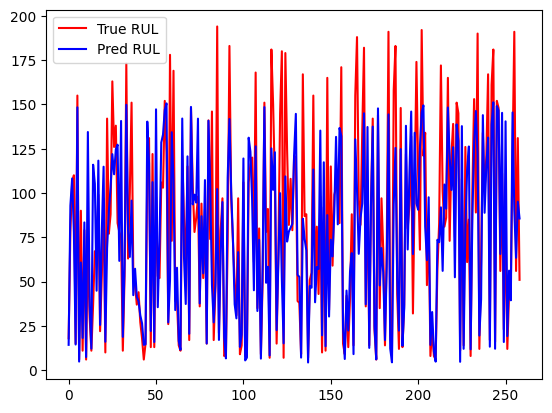

In [18]:
# Plot true and predicted RUL values
plt.plot(true_rul, label = "True RUL", color = "red")
plt.plot(preds_for_last_example, label = "Pred RUL", color = "blue")
plt.legend()
plt.show()

In [19]:
rul_pred = lstm_small_mse.predict(processed_test_data).reshape(-1)
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)

40/40 [==============================] - 0s 3ms/step
RMSE:  30.983827795362643


In [20]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE (Taking only last examples): ", RMSE_new)

RMSE (Taking only last examples):  31.399875003480712


In [24]:
s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score(MSE network): ", s_score)

S-score(MSE network):  54275.42099183268


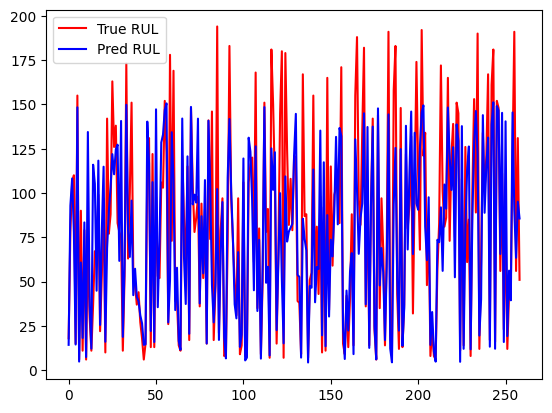

In [25]:
plt.plot(true_rul, label = "True RUL", color = "red")
plt.plot(preds_for_last_example, label = "Pred RUL", color = "blue")
plt.legend()
plt.show()

# LSTM LARGE

In [26]:
def custom_loss_large(y_true, y_pred):
    alpha = 0.4
    difference = y_pred - y_true
    squared_difference = tf.square(y_pred - y_true)
    
    # Calcola la loss per ciascun elemento
    loss = tf.where(difference < 0, 2 * alpha * squared_difference, 2 * (alpha + (1 - 2 * alpha)) * squared_difference)
    
    # Calcola la media delle loss
    return tf.reduce_mean(loss)

In [27]:
from keras.layers import Dropout

def createLSTMlargeModel(l1Nodes, l2Nodes, l3Nodes, l4Nodes, d1dense , d2dense, input_shape): 
    lstm1 = LSTM(l1Nodes, input_shape=input_shape, return_sequences=True, kernel_regularizer=regularizers.l2(0.1))
    d1 = Dropout(0.2)
    lstm2 = LSTM(l2Nodes, return_sequences=True, kernel_regularizer=regularizers.l2(0.1))
    d2 = Dropout(0.2)
    lstm3 = LSTM(l3Nodes, return_sequences=True, kernel_regularizer=regularizers.l2(0.1))
    d3 = Dropout(0.2)
    lstm4 = LSTM(l4Nodes, return_sequences=True, kernel_regularizer=regularizers.l2(0.1))
    d4 = Dropout(0.2)

    flatten = Flatten()

    dense1 = Dense(d1dense,activation='relu', kernel_regularizer=regularizers.l2(0.1))
    dense2 = Dense(d2dense,activation='relu', kernel_regularizer=regularizers.l2(0.1))
    output_dense = Dense(1,activation='relu', kernel_regularizer=regularizers.l2(0.1))

    layers = [lstm1,d1, lstm2,d2, lstm3, d3, lstm4, d4,flatten,  dense1, dense2, output_dense]
   
    
    model = Sequential(layers)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss=custom_loss_large)
    #model.compile(optimizer=optimizer, loss="mse", metrics = [custom_score])
    return model


In [28]:
LSTMlargeModel= createLSTMlargeModel(128, 64, 32, 16, 64, 32, (30,21))

In [29]:
def scheduler2(epoch, lr):
    if epoch < 30:
        return lr
    elif epoch >= 30 and epoch < 60 :
        return 0.001
    elif epoch >= 60 and epoch < 90: 
        return 0.0001
    elif epoch >= 90: 
        return 0.00001
    else: 
        return 0.01; 

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler2, verbose = 1)

In [30]:
EPOCHS = 100
history = LSTMlargeModel.fit(processed_train_data, 
                             processed_train_targets, 
                        epochs = EPOCHS, 
                     validation_data = (processed_val_data, processed_val_targets), 
                     callbacks = lr_scheduler, 
                     batch_size=BATCH_SIZE)


Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/100
145/145 [==============================] - 8s 22ms/step - loss: 2593.9668 - val_loss: 2357.4749 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 2/100
145/145 [==============================] - 2s 15ms/step - loss: 2382.9341 - val_loss: 2414.7761 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 3/100
145/145 [==============================] - 2s 17ms/step - loss: 2369.2288 - val_loss: 2348.1184 - lr: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 4/100
145/145 [==============================] - 2s 15ms/step - loss: 2341.4529 - val_loss: 2240.0859 - lr: 0.0100

Epoch 5: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 5/100
145/145 [==============================] - 2s 17ms/step - loss: 2051.7346 - val_loss: 1699.1204 - lr: 0.0100


In [31]:
rul_pred = LSTMlargeModel.predict(processed_test_data).reshape(-1)
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE (LARGE MODEL QUAD): ", RMSE)

40/40 [==============================] - 1s 7ms/step
RMSE (LARGE MODEL QUAD):  31.69733202774183


In [32]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE (Taking only last examples): ", RMSE_new)

RMSE (Taking only last examples):  31.670740456441084


In [33]:
s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score (LARGE MODEL QUAD): ", s_score)

S-score (LARGE MODEL QUAD):  44252.685666410485


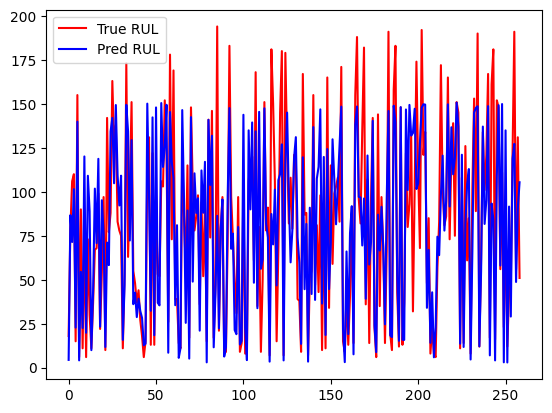

In [34]:
plt.plot(true_rul, label = "True RUL", color = "red")
plt.plot(preds_for_last_example, label = "Pred RUL", color = "blue")
plt.legend()
plt.show()

In [35]:
def createLSTMlargeModelMSE(l1Nodes, l2Nodes, l3Nodes, l4Nodes, d1dense , d2dense, input_shape): 
    lstm1 = LSTM(l1Nodes, input_shape=input_shape, return_sequences=True, kernel_regularizer=regularizers.l2(0.1))
    d1 = Dropout(0.2)
    lstm2 = LSTM(l2Nodes, return_sequences=True, kernel_regularizer=regularizers.l2(0.1))
    d2 = Dropout(0.2)
    lstm3 = LSTM(l3Nodes, return_sequences=True, kernel_regularizer=regularizers.l2(0.1))
    d3 = Dropout(0.2)
    lstm4 = LSTM(l4Nodes, return_sequences=True, kernel_regularizer=regularizers.l2(0.1))
    d4 = Dropout(0.2)

    flatten = Flatten()

    dense1 = Dense(d1dense,activation='relu', kernel_regularizer=regularizers.l2(0.1))
    dense2 = Dense(d2dense,activation='relu', kernel_regularizer=regularizers.l2(0.1))
    output_dense = Dense(1,activation='relu', kernel_regularizer=regularizers.l2(0.1))

    layers = [lstm1,d1, lstm2,d2, lstm3, d3, lstm4, d4,flatten,  dense1, dense2, output_dense]
   
    
    model = Sequential(layers)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss=custom_loss_large)
    #model.compile(optimizer=optimizer, loss="mse", metrics = [custom_score])
    return model

In [36]:
LSTMlargeModelMSE= createLSTMlargeModelMSE(128, 64, 32, 16, 64, 32, (30,21))

In [37]:
EPOCHS = 100
history = LSTMlargeModelMSE.fit(processed_train_data, 
                             processed_train_targets, 
                        epochs = EPOCHS, 
                     validation_data = (processed_val_data, processed_val_targets), 
                     callbacks = lr_scheduler, 
                     batch_size=BATCH_SIZE)


Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/100
145/145 [==============================] - 8s 23ms/step - loss: 2564.0059 - val_loss: 2387.4600 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 2/100
145/145 [==============================] - 2s 16ms/step - loss: 2396.7534 - val_loss: 2427.1084 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 3/100
145/145 [==============================] - 2s 16ms/step - loss: 2393.8301 - val_loss: 2393.8394 - lr: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 4/100
145/145 [==============================] - 2s 16ms/step - loss: 2533.3167 - val_loss: 2411.0105 - lr: 0.0100

Epoch 5: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 5/100
145/145 [==============================] - 2s 16ms/step - loss: 2379.6025 - val_loss: 2386.6106 - lr: 0.0100


In [38]:
rul_pred = LSTMlargeModelMSE.predict(processed_test_data).reshape(-1)
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE (LARGE MODEL MSE): ", RMSE)

40/40 [==============================] - 1s 6ms/step
RMSE (LARGE MODEL MSE):  34.69003435409401


In [39]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE (Taking only last examples): ", RMSE_new)

RMSE (Taking only last examples):  34.34599706440057


In [40]:
s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score (LARGE MODEL MSE): ", s_score)

S-score (LARGE MODEL MSE):  102408.16543003077


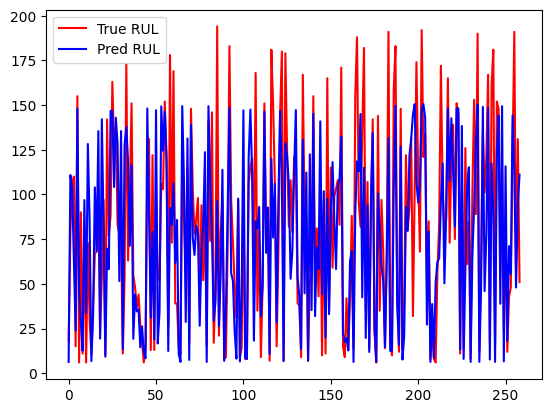

In [41]:
plt.plot(true_rul, label = "True RUL", color = "red")
plt.plot(preds_for_last_example, label = "Pred RUL", color = "blue")
plt.legend()
plt.show()

# CNN SMALL 

In [42]:
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
def create_CNN_small(): 
    cnn_small = Sequential(
        [
            layers.Conv1D(filters=64, kernel_size=8, activation='relu', input_shape=(30, 21)),
            layers.Conv1D(filters=32, kernel_size=6, activation='relu'),
            layers.Conv1D(filters=16, kernel_size=3, activation='relu'),
            layers.MaxPooling1D(pool_size=2),
            layers.Flatten(), 
            layers.Dense(units=32, activation='relu'),
            layers.Dense(units=1, activation='linear')
        ]
    )

    cnn_small.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss=custom_loss)
    return cnn_small

cnn_small = create_CNN_small()

In [43]:
EPOCHS = 50 #150 per la large
BATCH_SIZE = 128 #512 per la large


history = cnn_small.fit(processed_train_data, 
                             processed_train_targets, 
                        epochs = EPOCHS, 
                     validation_data = (processed_val_data, processed_val_targets), 
                     batch_size=BATCH_SIZE)

Epoch 1/50


2024-01-02 15:40:59.552071: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


289/289 [==============================] - 4s 7ms/step - loss: 1208.0881 - val_loss: 579.1448
Epoch 2/50
289/289 [==============================] - 2s 6ms/step - loss: 579.3295 - val_loss: 527.9686
Epoch 3/50
289/289 [==============================] - 2s 6ms/step - loss: 536.1083 - val_loss: 508.9111
Epoch 4/50
289/289 [==============================] - 2s 6ms/step - loss: 510.1516 - val_loss: 442.9616
Epoch 5/50
289/289 [==============================] - 2s 7ms/step - loss: 445.1193 - val_loss: 403.1389
Epoch 6/50
289/289 [==============================] - 2s 6ms/step - loss: 396.4293 - val_loss: 381.8010
Epoch 7/50
289/289 [==============================] - 2s 6ms/step - loss: 370.3858 - val_loss: 363.9049
Epoch 8/50
289/289 [==============================] - 2s 7ms/step - loss: 328.0147 - val_loss: 288.9428
Epoch 9/50
289/289 [==============================] - 2s 6ms/step - loss: 277.8048 - val_loss: 295.9086
Epoch 10/50
289/289 [==============================] - 2s 7ms/step - loss:

In [44]:
rul_pred = cnn_small.predict(processed_test_data).reshape(-1)
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE (LARGE MODEL MSE): ", RMSE)

40/40 [==============================] - 0s 4ms/step
RMSE (LARGE MODEL MSE):  36.26874324536791


In [45]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE (Taking only last examples): ", RMSE_new)

RMSE (Taking only last examples):  35.80644763305928


In [46]:
s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score (SMALL MODEL MSE): ", s_score)

S-score (SMALL MODEL MSE):  40750.05327836053


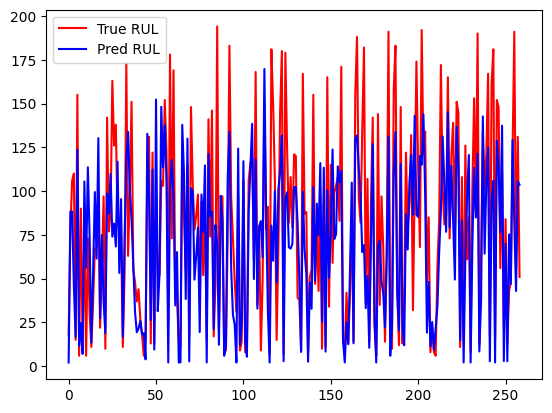

In [47]:
plt.plot(true_rul, label = "True RUL", color = "red")
plt.plot(preds_for_last_example, label = "Pred RUL", color = "blue")
plt.legend()
plt.show()

In [48]:
def create_CNN_large(): 
    cnn_small = Sequential(
        [
            layers.Conv1D(filters=128, kernel_size=8, activation='relu', input_shape=(30, 21)),
            layers.Conv1D(filters=64, kernel_size=6, activation='relu'),
            layers.Conv1D(filters=32, kernel_size=4, activation='relu'),
            layers.Conv1D(filters=16, kernel_size=2, activation='relu'),
            layers.MaxPooling1D(pool_size=2),
            layers.Flatten(), 
            layers.Dense(units=32, activation='relu'),
            layers.Dense(units=1, activation='linear')
        ]
    )

    cnn_small.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss=custom_loss)
    return cnn_small

cnn_large = create_CNN_large()
cnn_large.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 23, 128)           21632     
                                                                 
 conv1d_4 (Conv1D)           (None, 18, 64)            49216     
                                                                 
 conv1d_5 (Conv1D)           (None, 15, 32)            8224      
                                                                 
 conv1d_6 (Conv1D)           (None, 14, 16)            1040      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 7, 16)             0         
 g1D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 112)               0         
                                                      

In [49]:
EPOCHS = 50 #150 per la large
BATCH_SIZE = 512 #512 per la large


history = cnn_large.fit(processed_train_data, 
                             processed_train_targets, 
                        epochs = EPOCHS, 
                     validation_data = (processed_val_data, processed_val_targets), 
                     batch_size=BATCH_SIZE)

Epoch 1/50
73/73 [==============================] - 3s 15ms/step - loss: 1504.3119 - val_loss: 643.8213
Epoch 2/50
73/73 [==============================] - 1s 9ms/step - loss: 653.9817 - val_loss: 654.7340
Epoch 3/50
73/73 [==============================] - 1s 8ms/step - loss: 594.9624 - val_loss: 578.2837
Epoch 4/50
73/73 [==============================] - 1s 8ms/step - loss: 543.6467 - val_loss: 1017.4602
Epoch 5/50
73/73 [==============================] - 1s 8ms/step - loss: 770.3684 - val_loss: 504.4738
Epoch 6/50
73/73 [==============================] - 1s 9ms/step - loss: 542.8793 - val_loss: 533.9745
Epoch 7/50
73/73 [==============================] - 1s 8ms/step - loss: 501.9450 - val_loss: 670.9319
Epoch 8/50
73/73 [==============================] - 1s 8ms/step - loss: 463.8575 - val_loss: 414.1883
Epoch 9/50
73/73 [==============================] - 1s 8ms/step - loss: 701.9139 - val_loss: 554.0383
Epoch 10/50
73/73 [==============================] - 1s 9ms/step - loss: 451.90

In [50]:
rul_pred = cnn_large.predict(processed_test_data).reshape(-1)
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE (LARGE MODEL MSE): ", RMSE)

40/40 [==============================] - 0s 4ms/step
RMSE (LARGE MODEL MSE):  34.9498678763557


In [51]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE (Taking only last examples): ", RMSE_new)

RMSE (Taking only last examples):  33.959317446883695


In [52]:
s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score (SMALL MODEL MSE): ", s_score)

S-score (SMALL MODEL MSE):  35798.38362320947


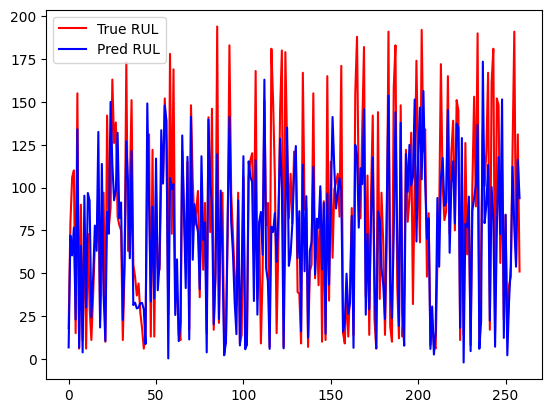

In [53]:
# Plot true and predicted RUL values
plt.plot(true_rul, label = "True RUL", color = "red")
plt.plot(preds_for_last_example, label = "Pred RUL", color = "blue")
plt.legend()
plt.show()

# CNN ALTERNATIVE 

In [54]:
def create_compiled_model():
    model = Sequential([
        layers.Conv1D(256, 7, activation = "relu", input_shape = (window_length, processed_train_data.shape[2])),
        layers.Conv1D(96, 7, activation = "relu"),
        layers.Conv1D(32, 7, activation = "relu"),
        layers.GlobalAveragePooling1D(),
        layers.Dense(64, activation = "relu"),
        layers.Dense(128, activation = "relu"),
        layers.Dense(1)
    ])
    model.compile(loss = "mse", optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))
    return model

In [55]:
def scheduler(epoch):
    if epoch < 10:
        return 0.001
    else:
        return 0.0001

In [56]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)

In [57]:
model = create_compiled_model()
history = model.fit(processed_train_data, processed_train_targets, epochs = 30,
                    validation_data = (processed_val_data, processed_val_targets),
                    callbacks = callback,
                    batch_size = 64, verbose = 2)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/30
578/578 - 6s - loss: 1283.1027 - val_loss: 847.4030 - lr: 0.0010 - 6s/epoch - 11ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/30
578/578 - 4s - loss: 814.5845 - val_loss: 1007.6617 - lr: 0.0010 - 4s/epoch - 7ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/30
578/578 - 4s - loss: 730.8728 - val_loss: 642.3754 - lr: 0.0010 - 4s/epoch - 7ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/30
578/578 - 4s - loss: 637.5953 - val_loss: 534.5427 - lr: 0.0010 - 4s/epoch - 7ms/step

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/30
578/578 - 4s - loss: 481.9915 - val_loss: 580.1720 - lr: 0.0010 - 4s/epoch - 7ms/step

Epoch 6: LearningRateScheduler setting learning rate to 0.001.
Epoch 6/30
578/578 - 4s - loss: 323.3236 - val_loss: 294.3549 - lr: 0.0010 - 4s/epoch - 7ms/step

Epoch 7: LearningRateScheduler

In [58]:
rul_pred = model.predict(processed_test_data).reshape(-1)
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)

40/40 [==============================] - 0s 5ms/step
RMSE:  34.12721041449645


In [59]:
ndices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE (Taking only last examples): ", RMSE_new)

RMSE (Taking only last examples):  33.82898640650868


In [60]:
s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score: ", s_score)


S-score:  64150.73729144975


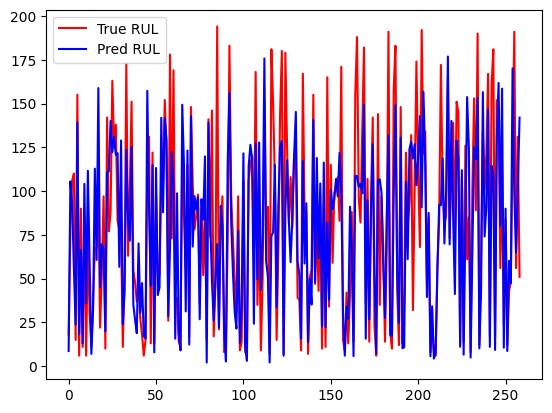

In [61]:
# Plot true and predicted RUL values
plt.plot(true_rul, label = "True RUL", color = "red")
plt.plot(preds_for_last_example, label = "Pred RUL", color = "blue")
plt.legend()
plt.show()

In [62]:
def create_compiled_model_quad():
    model = Sequential([
        layers.Conv1D(256, 7, activation = "relu", input_shape = (window_length, processed_train_data.shape[2])),
        layers.Conv1D(96, 7, activation = "relu"),
        layers.Conv1D(32, 7, activation = "relu"),
        layers.GlobalAveragePooling1D(),
        layers.Dense(64, activation = "relu"),
        layers.Dense(128, activation = "relu"),
        layers.Dense(1)
    ])
    model.compile(loss = custom_loss, optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))
    return model

cnn_alternative_quad = create_compiled_model_quad()
cnn_alternative_quad.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 24, 256)           37888     
                                                                 
 conv1d_11 (Conv1D)          (None, 18, 96)            172128    
                                                                 
 conv1d_12 (Conv1D)          (None, 12, 32)            21536     
                                                                 
 global_average_pooling1d_1  (None, 32)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_19 (Dense)            (None, 64)                2112      
                                                                 
 dense_20 (Dense)            (None, 128)               8320      
                                                      

In [63]:
EPOCHS = 30
BATCH_SIZE = 64 
history = cnn_alternative_quad.fit(processed_train_data, processed_train_targets, epochs = EPOCHS,
                    validation_data = (processed_val_data, processed_val_targets),
                    callbacks = callback,
                    batch_size = BATCH_SIZE, verbose = 2)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/30
578/578 - 6s - loss: 880.7258 - val_loss: 583.8222 - lr: 0.0010 - 6s/epoch - 10ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/30
578/578 - 4s - loss: 579.8334 - val_loss: 521.4310 - lr: 0.0010 - 4s/epoch - 7ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/30
578/578 - 4s - loss: 532.7928 - val_loss: 488.4188 - lr: 0.0010 - 4s/epoch - 7ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/30
578/578 - 4s - loss: 482.9951 - val_loss: 520.2960 - lr: 0.0010 - 4s/epoch - 7ms/step

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/30
578/578 - 4s - loss: 388.6993 - val_loss: 324.5769 - lr: 0.0010 - 4s/epoch - 7ms/step

Epoch 6: LearningRateScheduler setting learning rate to 0.001.
Epoch 6/30
578/578 - 4s - loss: 250.1427 - val_loss: 216.5789 - lr: 0.0010 - 4s/epoch - 7ms/step

Epoch 7: LearningRateScheduler s

In [64]:
rul_pred =cnn_alternative_quad.predict(processed_test_data).reshape(-1)
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)

40/40 [==============================] - 0s 3ms/step
RMSE:  34.67933074896162


In [65]:
ndices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE (Taking only last examples): ", RMSE_new)

RMSE (Taking only last examples):  34.74123596653209


In [66]:
s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score: ", s_score)


S-score:  59030.31571632706


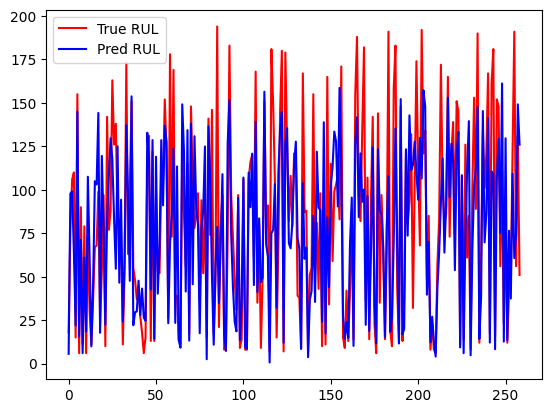

In [67]:
# Plot true and predicted RUL values
plt.plot(true_rul, label = "True RUL", color = "red")
plt.plot(preds_for_last_example, label = "Pred RUL", color = "blue")
plt.legend()
plt.show()

In [68]:
from tflite_converter import convert_to_tflite
MODEL_DIR = '../models/FD002/LSTMsmall/QUAD-QUAD/'
BATCH_SIZE = 1
STEPS = 30 
INPUT_SIZE = 21
nome = "lstm_small_batch_1"
convert_to_tflite(MODEL_DIR, BATCH_SIZE, STEPS, INPUT_SIZE, lstm_small_quad, nome)

INFO:tensorflow:Assets written to: ../models/FD002/LSTMsmall/QUAD-QUAD/assets


INFO:tensorflow:Assets written to: ../models/FD002/LSTMsmall/QUAD-QUAD/assets
/home/aliquodfahriam/tinyML/Riproduzione/FD002/tflite_converter.py:16: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(modello, nome_modello+".h5")
2024-01-02 15:47:29.686726: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-01-02 15:47:29.686770: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-01-02 15:47:29.693053: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: ../models/FD002/LSTMsmall/QUAD-QUAD/
2024-01-02 15:47:29.716242: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-01-02 15:47:29.716282: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel d

In [69]:

MODEL_DIR = '../models/FD002/LSTMsmall/MSE/'
BATCH_SIZE = 1
STEPS = 30 
INPUT_SIZE = 21
nome = "lstm_small_batch_1_MSE"
convert_to_tflite(MODEL_DIR, BATCH_SIZE, STEPS, INPUT_SIZE, lstm_small_mse, nome)

INFO:tensorflow:Assets written to: ../models/FD002/LSTMsmall/MSE/assets


INFO:tensorflow:Assets written to: ../models/FD002/LSTMsmall/MSE/assets
/home/aliquodfahriam/tinyML/Riproduzione/FD002/tflite_converter.py:16: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(modello, nome_modello+".h5")
2024-01-02 15:47:37.959614: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-01-02 15:47:37.959656: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-01-02 15:47:37.959985: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: ../models/FD002/LSTMsmall/MSE/
2024-01-02 15:47:37.985760: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-01-02 15:47:37.985809: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (i

In [70]:
MODEL_DIR = '../models/FD002/LSTMlarge/QUAD-QUAD/'
BATCH_SIZE = 1
STEPS = 30 
INPUT_SIZE = 21
nome = "lstm_large_batch_1_QUAD"
convert_to_tflite(MODEL_DIR, BATCH_SIZE, STEPS, INPUT_SIZE, LSTMlargeModel, nome)

INFO:tensorflow:Assets written to: ../models/FD002/LSTMlarge/QUAD-QUAD/assets


INFO:tensorflow:Assets written to: ../models/FD002/LSTMlarge/QUAD-QUAD/assets
/home/aliquodfahriam/tinyML/Riproduzione/FD002/tflite_converter.py:16: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(modello, nome_modello+".h5")
2024-01-02 15:47:53.002588: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-01-02 15:47:53.002630: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-01-02 15:47:53.002915: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: ../models/FD002/LSTMlarge/QUAD-QUAD/
2024-01-02 15:47:53.037462: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-01-02 15:47:53.037514: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel d

In [71]:

MODEL_DIR = '../models/FD002/LSTMlarge/MSE/'
BATCH_SIZE = 1
STEPS = 30 
INPUT_SIZE = 21
nome = "lstm_large_batch_1_MSE"
convert_to_tflite(MODEL_DIR, BATCH_SIZE, STEPS, INPUT_SIZE, LSTMlargeModelMSE, nome)

INFO:tensorflow:Assets written to: ../models/FD002/LSTMlarge/MSE/assets


INFO:tensorflow:Assets written to: ../models/FD002/LSTMlarge/MSE/assets
/home/aliquodfahriam/tinyML/Riproduzione/FD002/tflite_converter.py:16: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(modello, nome_modello+".h5")
2024-01-02 15:48:08.406421: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-01-02 15:48:08.406466: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-01-02 15:48:08.406737: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: ../models/FD002/LSTMlarge/MSE/
2024-01-02 15:48:08.438968: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-01-02 15:48:08.439018: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (i

In [72]:
MODEL_DIR = '../models/FD002/CNNAlternativeQUAD'
BATCH_SIZE = 1
STEPS = 30 
INPUT_SIZE = 21
nome = "CNN_alternative_QUAD_batch_1"
convert_to_tflite(MODEL_DIR, BATCH_SIZE, STEPS, INPUT_SIZE, cnn_alternative_quad, nome)

INFO:tensorflow:Assets written to: ../models/FD002/CNNAlternativeQUAD/assets


INFO:tensorflow:Assets written to: ../models/FD002/CNNAlternativeQUAD/assets
/home/aliquodfahriam/tinyML/Riproduzione/FD002/tflite_converter.py:16: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(modello, nome_modello+".h5")
2024-01-02 15:48:10.625048: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-01-02 15:48:10.625085: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-01-02 15:48:10.625314: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: ../models/FD002/CNNAlternativeQUAD
2024-01-02 15:48:10.627652: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-01-02 15:48:10.627683: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debu

In [73]:
MODEL_DIR = '../models/FD002/CNNlargeQuad'
BATCH_SIZE = 1
STEPS = 30 
INPUT_SIZE = 21
nome = "CNN_large_QUAD_batch_1"
convert_to_tflite(MODEL_DIR, BATCH_SIZE, STEPS, INPUT_SIZE, cnn_alternative_quad, nome)

INFO:tensorflow:Assets written to: ../models/FD002/CNNlargeQuad/assets


INFO:tensorflow:Assets written to: ../models/FD002/CNNlargeQuad/assets
/home/aliquodfahriam/tinyML/Riproduzione/FD002/tflite_converter.py:16: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(modello, nome_modello+".h5")
2024-01-02 15:48:11.869204: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-01-02 15:48:11.869242: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-01-02 15:48:11.869481: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: ../models/FD002/CNNlargeQuad
2024-01-02 15:48:11.871847: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-01-02 15:48:11.871878: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if p

In [74]:
MODEL_DIR = '../models/FD002/CNNSmallQUAD'
BATCH_SIZE = 1
STEPS = 30 
INPUT_SIZE = 21
nome = "CNN_small_QUAD"
convert_to_tflite(MODEL_DIR, BATCH_SIZE, STEPS, INPUT_SIZE, cnn_small, nome)

INFO:tensorflow:Assets written to: ../models/FD002/CNNSmallQUAD/assets


INFO:tensorflow:Assets written to: ../models/FD002/CNNSmallQUAD/assets
/home/aliquodfahriam/tinyML/Riproduzione/FD002/tflite_converter.py:16: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(modello, nome_modello+".h5")
2024-01-02 15:48:13.098941: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-01-02 15:48:13.098978: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-01-02 15:48:13.099212: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: ../models/FD002/CNNSmallQUAD
2024-01-02 15:48:13.101413: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-01-02 15:48:13.101446: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if p